# <center> meta-MERA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config

config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## energy
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [11]:
# j=1, Bx=1
def energy(c: tc.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= hx * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n-1):  
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i+1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

## meta-MERA net

In [5]:
def MERA(params, n, hx):
    params = tc.backend.cast(params, "complex128")
    hx = tc.backend.cast(hx, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    # encoding layer
    for i in range(n):
        c.rx(i, theta=(params[4*i] * hx + params[4*i+1]))
        c.rz(i, theta=(params[4*i+2] * hx + params[4*i+1+3]))
    idx += 4*n
    
    for i in range(0, n-1, 2):
        c.cnot(i, i+1)
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    
    # processing layer
    for n_layer in range(1, int(np.log2(n))+1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)

        # even    
        for i in range(step, n-step, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        # odd   
        for i in range(0, n, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        
        # c.barrier()

    # measure
    e = energy(c, hx=hx)
    #return c, idx
    return e

98


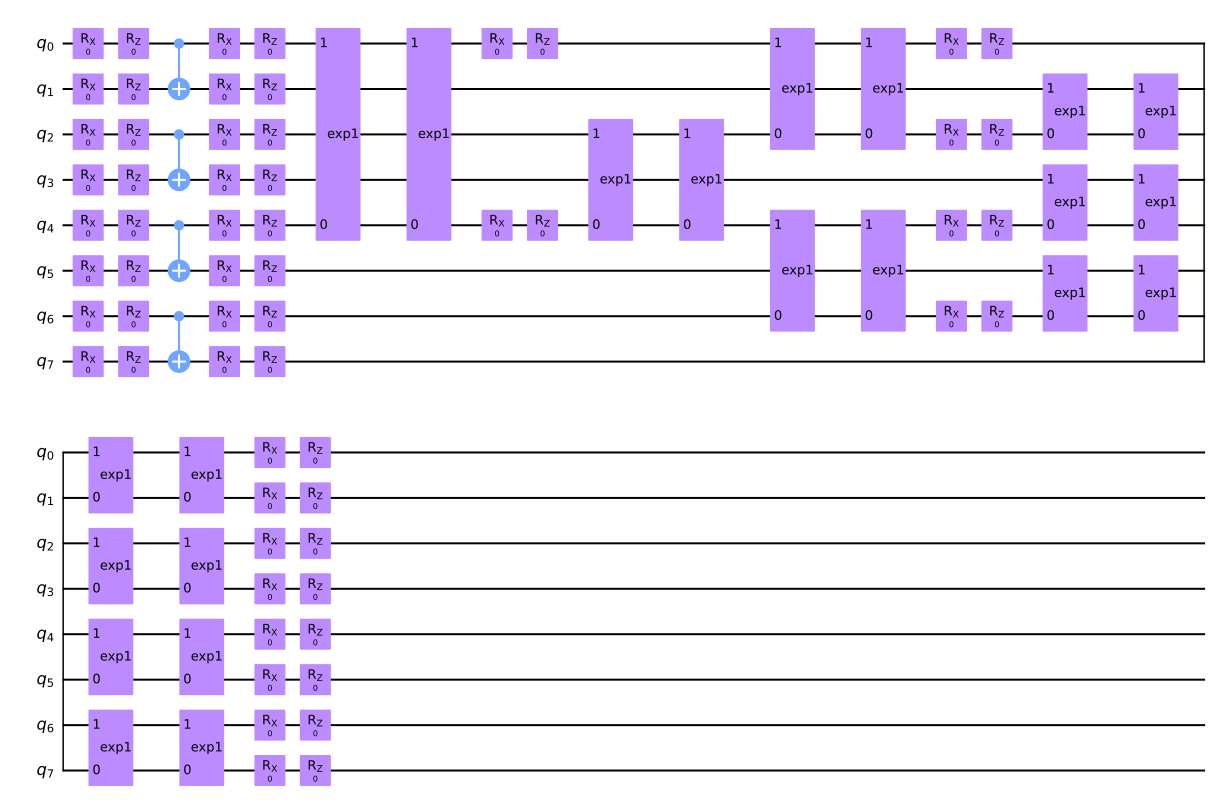

In [4]:
cirq, idx = MERA(np.zeros(1000), 8, 1)
print(idx)
cirq.draw()

In [6]:
def meta_MERA(params, n, hx):
    e_all = tf.zeros([1], dtype=tf.float64)
    for h in hx:
        e_all += MERA(params, n, h)
        
    return e_all

## train

In [7]:
meta_MERA_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(meta_MERA)
)

def batched_train(n, hx, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    best_params = None
    for i in range(maxiter):
        e, grad = meta_MERA_tfim_vvag(params, n, hx)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e)<lowest_energy:
            lowest_energy = tf.reduce_min(e)
            best_params = params[tf.argmin(e).numpy()[0]]
        if i % 200 == 0:
            print(e)
    return lowest_energy, best_params

In [9]:
n = 8
hx = tf.random.uniform(
    shape=[10], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
with tf.device('/cpu:0'):
    energy, best_params = batched_train(n, hx, batch=5, maxiter=3000, lr=0.007)

tf.Tensor(
[[ 4.90359499]
 [ 7.10630891]
 [-1.14378949]
 [17.74186953]
 [ 1.99235449]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-78.28434493]
 [-85.39180374]
 [-85.81332457]
 [-86.23565464]
 [-80.76975833]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-85.01286555]
 [-89.5359834 ]
 [-89.71613762]
 [-89.36446945]
 [-87.97140547]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-86.30775261]
 [-90.08927186]
 [-90.37639669]
 [-89.92803676]
 [-88.95390665]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-88.23519022]
 [-90.40357659]
 [-90.8066283 ]
 [-90.11403019]
 [-89.36282627]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-89.87043148]
 [-90.70666292]
 [-90.96004881]
 [-90.2521734 ]
 [-90.03381485]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-91.30628667]
 [-90.79589953]
 [-91.00254902]
 [-90.40799268]
 [-90.411195  ]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-91.45204131]
 [-90.83046029]
 [-91.03052504]
 [-90.55095755]
 [-90.62761906]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-91.52902743]
 [

## compare

In [12]:
# Creating test data
from tqdm.notebook import tqdm
test_hx = tf.random.uniform(
    shape=[100], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
test_energies = tf.zeros_like(test_hx).numpy()

for i, h in tqdm(enumerate(test_hx)):
    test_energies[i] = MERA(best_params, n, h).numpy()

0it [00:00, ?it/s]

In [13]:
import quimb
DMRG_energies = []
for i in np.linspace(0,1.6,17):
    h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4.0, bx=2*i, S=0.5, cyclic=False)  # Ising Hamiltonian in MPO form (number, zz interaction strenth, x-magnetic field strenth)
    dmrg = quimb.tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
    dmrg.solve(tol=1e-9, verbosity=0)
    DMRG_energies.append(dmrg.energy)

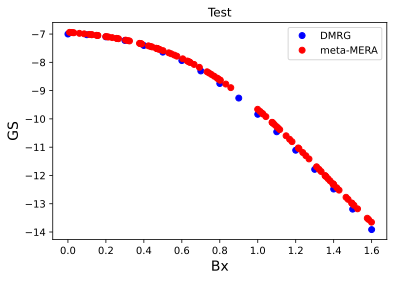

In [14]:
plt.plot(np.linspace(0,1.6,17), DMRG_energies, 'bo', label='DMRG')
plt.plot(test_hx, test_energies, 'ro', label='meta-MERA')
plt.title("Test")
plt.xlabel("Bx", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()

In [15]:
energy, best_params

(<function __main__.energy(c: tensorcircuit.circuit.Circuit, j: float = 1.0, hx: float = 1.0)>,
 <tf.Tensor: shape=(98,), dtype=float64, numpy=
 array([ 3.97062724e-02,  1.51952722e+00,  8.96108237e-01, -4.24334581e-01,
        -1.20893111e+00, -1.07652985e-01, -4.61855304e-01, -4.15398306e-01,
         7.24710645e-01, -3.73738113e-02, -2.44308290e-02,  7.49602025e-02,
        -3.27018439e-01, -1.42703705e+00, -5.53453318e-01, -6.98201605e-02,
         9.44275842e-03, -3.57551495e-03,  2.42452914e+00,  6.65020383e-01,
         9.97883602e-01, -1.41405783e-01,  1.82420591e-01, -1.11785383e+00,
         7.83955457e-01,  1.62480000e+00,  3.60783587e-02,  1.52374719e+00,
         8.03430852e-01,  4.69465566e-01,  4.64473060e-02,  7.11119663e-01,
         1.17142970e+00, -1.89172377e-01,  1.83260988e+00, -2.71093712e-01,
         3.06799094e+00,  1.19264182e+00,  1.66110748e-01, -1.68697773e+00,
        -1.11048630e-01, -9.79908941e-01, -1.02919683e+00,  6.57414445e-01,
        -5.08647080e

In [16]:
test_hx, test_energies

(<tf.Tensor: shape=(100,), dtype=float64, numpy=
 array([0.26656246, 1.02282964, 1.38104812, 1.58401837, 0.15050561,
        0.38849916, 1.42844482, 1.09948228, 0.77073211, 0.56073436,
        1.46521202, 0.73298968, 0.50127433, 1.25352654, 1.07695418,
        0.08540089, 1.35493335, 1.50713346, 0.03114983, 1.27006568,
        1.32271483, 1.35951814, 1.49498103, 0.37695218, 0.47234325,
        1.02774566, 1.52581418, 1.16782937, 1.39516226, 0.00844772,
        0.32436803, 1.07949924, 0.20715598, 0.54395254, 0.21414985,
        1.18057382, 1.39843142, 0.25628881, 0.44374724, 0.63828371,
        1.07531173, 0.63842553, 1.10753693, 0.80241847, 1.21726377,
        0.12702912, 0.83175042, 0.4352437 , 1.11588602, 0.60505186,
        0.69261395, 0.66468051, 0.46454487, 0.6446062 , 0.42415141,
        1.33395984, 0.75619082, 1.08730091, 0.47148308, 1.14931223,
        1.41628697, 0.57405103, 0.01665361, 0.30370612, 0.46704372,
        0.25791144, 0.99947494, 0.06044962, 0.19925818, 1.35570417,